# Invariant VAE and sample complexity

In [1]:
#@title Installation and Imports

# !pip install -qq pyro-ppl

from typing import Optional, Tuple, Type, Union

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pyro
import pyro.distributions as dist
import pyro.infer as infer
import pyro.optim as optim
import torch
import torch.nn as nn
from scipy.stats import norm
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import warnings
warnings.filterwarnings("ignore", module="torchvision.datasets")

/home/gridsan/ggupta/.conda/envs/my_env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from src.rvae import *
from src.models import *
from src.functions import *
from src.trainer import *
from src.data import *
from src.classifier import *

Get rotated MNIST data and pass it to dataloader that will be used for (r)VAE training:

In [3]:
mnist_trainset = datasets.MNIST('data/mnist/', train=True, download=True)
mnist_testset = datasets.MNIST('data/mnist/', train=False, download=True)
train_data, train_labels, train_angles = get_rotated_mnist(mnist_trainset, rotation_range=[-60, 61])
test_data, test_labels, test_angles = get_rotated_mnist(mnist_testset, rotation_range=[-60, 61])
train_loader = init_dataloader(train_data, batch_size=100)
test_loader = init_dataloader(test_data, batch_size=100)
# train_loader = init_dataloader(train_data, batch_size=200)

In [4]:
print(device)

cuda


## Vanilla VAE

In [6]:
mnist_trainset = datasets.MNIST('data/mnist/', train=True, download=True)
mnist_testset = datasets.MNIST('data/mnist/', train=False, download=True)

In [7]:
def train_vae(path, latent_dim, n_samples):
    train_data, train_labels, train_angles = get_rotated_mnist_sample(mnist_trainset, n_samples = n_samples, rotation_range=[-60, 61])
    train_loader = init_dataloader(train_data, batch_size=100)

    in_dim = (28, 28)
    # Initialize probabilistic VAE model ->
    # (coord=0: vanilla VAE
    #  coord=1: rotations only
    #  coord=2: translations only
    #  coord=3: rotations+translations)
    vae = rVAE(in_dim, latent_dim=latent_dim, coord=0, seed=0)

    # # Initialize SVI trainer
    trainer = SVItrainer(vae)
    # Train for n epochs:
    for e in range(100):
        trainer.step(train_loader)
#         trainer.print_statistics()
    trainer.save_model(vae, path)

In [8]:
%%capture cap_f1
# train_vae('saved_models/vae_rotation_z_100_samples_200.pkl', 100, 200)
# train_vae('saved_models/vae_rotation_z_100_samples_1000.pkl', 100, 1000)
# train_vae('saved_models/vae_rotation_z_100_samples_2000.pkl', 100, 2000)
# train_vae('saved_models/vae_rotation_z_100_samples_3000.pkl', 100, 3000)
# train_vae('saved_models/vae_rotation_z_100_samples_4000.pkl', 100, 4000)
# train_vae('saved_models/vae_rotation_z_100_samples_5000.pkl', 100, 5000)
# train_vae('saved_models/vae_rotation_z_100_samples_6000.pkl', 100, 6000)

# train_vae('saved_models/vae_rotation_z_10_samples_200.pkl', 10, 200)
# train_vae('saved_models/vae_rotation_z_10_samples_1000.pkl', 10, 1000)
# train_vae('saved_models/vae_rotation_z_10_samples_2000.pkl', 10, 2000)
# train_vae('saved_models/vae_rotation_z_10_samples_3000.pkl', 10, 3000)
# train_vae('saved_models/vae_rotation_z_10_samples_4000.pkl', 10, 4000)
# train_vae('saved_models/vae_rotation_z_10_samples_5000.pkl', 10, 5000)
# train_vae('saved_models/vae_rotation_z_10_samples_6000.pkl', 10, 6000)

# train_vae('saved_models/vae_rotation_z_2_samples_200.pkl', 2, 200)
# train_vae('saved_models/vae_rotation_z_2_samples_1000.pkl', 2, 1000)
# train_vae('saved_models/vae_rotation_z_2_samples_2000.pkl', 2, 2000)
# train_vae('saved_models/vae_rotation_z_2_samples_3000.pkl', 2, 3000)
# train_vae('saved_models/vae_rotation_z_2_samples_4000.pkl', 2, 4000)
# train_vae('saved_models/vae_rotation_z_2_samples_5000.pkl', 2, 5000)
# train_vae('saved_models/vae_rotation_z_2_samples_6000.pkl', 2, 6000)

In [9]:
import pickle
mnist_trainset = datasets.MNIST('data/mnist/', train=True, download=True)
mnist_testset = datasets.MNIST('data/mnist/', train=False, download=True)
device = 'cpu'
def train_classifier_vae(latent_dim, n_samples, path_vae, results_path):
#     mnist_train = datasets.MNIST('data/mnist/', train=True, download=True, transform=transforms.Compose([transforms.ToTensor()]))
#     mnist_test = datasets.MNIST('data/mnist/', train=False, download=True, transform=transforms.Compose([transforms.ToTensor()]))
    train_data, train_labels, train_angles = get_rotated_mnist_sample(mnist_trainset, n_samples = n_samples, rotation_range=[-60, 61])
    test_data, test_labels, test_angles = get_rotated_mnist_sample(mnist_testset, n_samples = n_samples, rotation_range=[-60, 61])
    trainset = [[train_data[i], train_labels[i]] for i in range(len(train_data))]
    testset = [[test_data[i], test_labels[i]] for i in range(len(test_data))]
        
    model = MLP(in_channels= latent_dim)
    model.to(device)
    
    in_dim = (28, 28)
    vae = rVAE(in_dim, latent_dim=latent_dim, coord=0, seed=0)
    trainer = SVItrainer(vae)
    trainer.load_model(vae, path_vae)
    mlp_mnist_results = train_nn(model, vae, trainset, testset, num_epochs = 100)
    with open(results_path, 'wb') as handle:
        pickle.dump(mlp_mnist_results, handle, protocol=pickle.HIGHEST_PROTOCOL)
#     torch.save(model.state_dict(), 'saved_models/vae_rotated_mnist_classifier.pkl')    
#     with open('saved_models/dict_vae_rotated_mnist_classifier.pkl', 'rb') as handle:
#         results = pickle.load(handle)
#     model.load_state_dict(torch.load('saved_models/vae_rotated_mnist_classifier.pkl'))


In [10]:
%%capture cap_f1
# train_classifier_vae(100, 200, 'saved_models/vae_rotation_z_100_samples_200.pkl', 'saved_models/dict_vae_z_100_rotated_classifier_200.pkl')
# train_classifier_vae(100, 1000, 'saved_models/vae_rotation_z_100_samples_1000.pkl', 'saved_models/dict_vae_z_100_rotated_classifier_1000.pkl')
train_classifier_vae(100, 2000, 'saved_models/vae_rotation_z_100_samples_2000.pkl', 'saved_models/dict_vae_z_100_rotated_classifier_2000.pkl')
# train_classifier_vae(100, 3000, 'saved_models/vae_rotation_z_100_samples_3000.pkl', 'saved_models/dict_vae_z_100_rotated_classifier_3000.pkl')
# train_classifier_vae(100, 4000, 'saved_models/vae_rotation_z_100_samples_4000.pkl', 'saved_models/dict_vae_z_100_rotated_classifier_4000.pkl')
# train_classifier_vae(100, 5000, 'saved_models/vae_rotation_z_100_samples_5000.pkl', 'saved_models/dict_vae_z_100_rotated_classifier_5000.pkl')
# train_classifier_vae(100, 6000, 'saved_models/vae_rotation_z_100_samples_6000.pkl', 'saved_models/dict_vae_z_100_rotated_classifier_6000.pkl')

# train_classifier_vae(10, 200, 'saved_models/vae_rotation_z_10_samples_200.pkl', 'saved_models/dict_vae_z_10_rotated_classifier_200.pkl')
# train_classifier_vae(10, 1000, 'saved_models/vae_rotation_z_10_samples_1000.pkl', 'saved_models/dict_vae_z_10_rotated_classifier_1000.pkl')
# train_classifier_vae(10, 2000, 'saved_models/vae_rotation_z_10_samples_2000.pkl', 'saved_models/dict_vae_z_10_rotated_classifier_2000.pkl')
# train_classifier_vae(10, 3000, 'saved_models/vae_rotation_z_10_samples_3000.pkl', 'saved_models/dict_vae_z_10_rotated_classifier_3000.pkl')
# train_classifier_vae(10, 4000, 'saved_models/vae_rotation_z_10_samples_4000.pkl', 'saved_models/dict_vae_z_10_rotated_classifier_4000.pkl')
# train_classifier_vae(10, 5000, 'saved_models/vae_rotation_z_10_samples_5000.pkl', 'saved_models/dict_vae_z_10_rotated_classifier_5000.pkl')
# train_classifier_vae(10, 6000, 'saved_models/vae_rotation_z_10_samples_6000.pkl', 'saved_models/dict_vae_z_10_rotated_classifier_6000.pkl')

# train_classifier_vae(2, 200, 'saved_models/vae_rotation_z_2_samples_200.pkl', 'saved_models/dict_vae_z_2_rotated_classifier_200.pkl')
# train_classifier_vae(2, 1000, 'saved_models/vae_rotation_z_2_samples_1000.pkl', 'saved_models/dict_vae_z_2_rotated_classifier_1000.pkl')
# train_classifier_vae(2, 2000, 'saved_models/vae_rotation_z_2_samples_2000.pkl', 'saved_models/dict_vae_z_2_rotated_classifier_2000.pkl')
# train_classifier_vae(2, 3000, 'saved_models/vae_rotation_z_2_samples_3000.pkl', 'saved_models/dict_vae_z_2_rotated_classifier_3000.pkl')
# train_classifier_vae(2, 4000, 'saved_models/vae_rotation_z_2_samples_4000.pkl', 'saved_models/dict_vae_z_2_rotated_classifier_4000.pkl')
# train_classifier_vae(2, 5000, 'saved_models/vae_rotation_z_2_samples_5000.pkl', 'saved_models/dict_vae_z_2_rotated_classifier_5000.pkl')
# train_classifier_vae(2, 6000, 'saved_models/vae_rotation_z_2_samples_6000.pkl', 'saved_models/dict_vae_z_2_rotated_classifier_6000.pkl')


## Rotationally-invariant VAE (rVAE)

In [10]:
mnist_trainset = datasets.MNIST('data/mnist/', train=True, download=True)
mnist_testset = datasets.MNIST('data/mnist/', train=False, download=True)

In [11]:
def train_rvae(path, latent_dim, n_samples):
    train_data, train_labels, train_angles = get_rotated_mnist_sample(mnist_trainset, n_samples = n_samples, rotation_range=[-60, 61])
    train_loader = init_dataloader(train_data, batch_size=100)

    in_dim = (28, 28)
    # Initialize probabilistic VAE model ->
    # (coord=0: vanilla VAE
    #  coord=1: rotations only
    #  coord=2: translations only
    #  coord=3: rotations+translations)
    rvae = rVAE(in_dim, latent_dim=latent_dim, coord=1, seed=0)

    # # Initialize SVI trainer
    trainer = SVItrainer(rvae)
    # Train for n epochs:
    for e in range(100):
        trainer.step(train_loader)
#         trainer.print_statistics()
    trainer.save_model(rvae, path)

In [ ]:
# train_rvae('saved_models/rvae_rotation_z_100_samples_200.pkl', 100, 200)
# train_rvae('saved_models/rvae_rotation_z_100_samples_1000.pkl', 100, 1000)
# train_rvae('saved_models/rvae_rotation_z_100_samples_2000.pkl', 100, 2000)
# train_rvae('saved_models/rvae_rotation_z_100_samples_3000.pkl', 100, 3000)
# train_rvae('saved_models/rvae_rotation_z_100_samples_4000.pkl', 100, 4000)
# train_rvae('saved_models/rvae_rotation_z_100_samples_5000.pkl', 100, 5000)
# train_rvae('saved_models/rvae_rotation_z_100_samples_6000.pkl', 100, 6000)

# train_rvae('saved_models/rvae_rotation_z_10_samples_200.pkl', 10, 200)
# train_rvae('saved_models/rvae_rotation_z_10_samples_1000.pkl', 10, 1000)
# train_rvae('saved_models/rvae_rotation_z_10_samples_2000.pkl', 10, 2000)
# train_rvae('saved_models/rvae_rotation_z_10_samples_3000.pkl', 10, 3000)
# train_rvae('saved_models/rvae_rotation_z_10_samples_4000.pkl', 10, 4000)
# train_rvae('saved_models/rvae_rotation_z_10_samples_5000.pkl', 10, 5000)
# train_rvae('saved_models/rvae_rotation_z_10_samples_6000.pkl', 10, 6000)

train_rvae('saved_models/rvae_rotation_z_2_samples_200.pkl', 2, 200)
train_rvae('saved_models/rvae_rotation_z_2_samples_1000.pkl', 2, 1000)
train_rvae('saved_models/rvae_rotation_z_2_samples_2000.pkl', 2, 2000)
train_rvae('saved_models/rvae_rotation_z_2_samples_3000.pkl', 2, 3000)
train_rvae('saved_models/rvae_rotation_z_2_samples_4000.pkl', 2, 4000)
train_rvae('saved_models/rvae_rotation_z_2_samples_5000.pkl', 2, 5000)
train_rvae('saved_models/rvae_rotation_z_2_samples_6000.pkl', 2, 6000)

In [ ]:
import pickle
mnist_trainset = datasets.MNIST('data/mnist/', train=True, download=True)
mnist_testset = datasets.MNIST('data/mnist/', train=False, download=True)

def train_classifier_rave(latent_dim, n_samples, path_rvae, results_path):
    # mnist_train = datasets.MNIST('data/mnist/', train=True, download=True, transform=transforms.Compose([transforms.ToTensor()]))
    # mnist_test = datasets.MNIST('data/mnist/', train=False, download=True, transform=transforms.Compose([transforms.ToTensor()]))
    mnist_trainset = datasets.MNIST('data/mnist/', train=True, download=True)
    mnist_testset = datasets.MNIST('data/mnist/', train=False, download=True)
    train_data, train_labels, train_angles = get_rotated_mnist_sample(mnist_trainset, n_samples = n_samples, rotation_range=[-60, 61])
    test_data, test_labels, test_angles = get_rotated_mnist_sample(mnist_testset, n_samples = n_samples, rotation_range=[-60, 61])
    mnist_trainset = [[train_data[i], train_labels[i]] for i in range(len(train_data))]
    mnist_testset = [[test_data[i], test_labels[i]] for i in range(len(test_data))]
    
    
    model = MLP(in_channels=latent_dim)
    model.to(device)
    
    in_dim = (28, 28)
    rvae = rVAE(in_dim, latent_dim=latent_dim, coord=1, seed=0)
    trainer = SVItrainer(rvae)
    trainer.load_model(rvae, path_rvae)
    mlp_mnist_results = train_nn(model, rvae, mnist_trainset, mnist_testset, num_epochs = 100)
    with open(results_path, 'wb') as handle:
        pickle.dump(mlp_mnist_results, handle, protocol=pickle.HIGHEST_PROTOCOL)
#     torch.save(model.state_dict(), 'saved_models/vae_rotated_mnist_classifier.pkl')    

#     with open('saved_models/dict_vae_rotated_mnist_classifier.pkl', 'rb') as handle:
#         results = pickle.load(handle)
#     model.load_state_dict(torch.load('saved_models/vae_rotated_mnist_classifier.pkl'))


In [ ]:
%%capture cap_f1
# train_classifier_rave(100, 200, 'saved_models/rvae_rotation_z_100_samples_200.pkl', 'saved_models/dict_rvae_z_100_rotated_classifier_200.pkl')
# train_classifier_rave(100, 1000, 'saved_models/rvae_rotation_z_100_samples_1000.pkl', 'saved_models/dict_rvae_z_10_rotated_classifier_1000.pkl')
# train_classifier_rave(100, 2000, 'saved_models/rvae_rotation_z_100_samples_2000.pkl', 'saved_models/dict_rvae_z_100_rotated_classifier_2000.pkl')
# train_classifier_rave(100, 4000, 'saved_models/rvae_rotation_z_100_samples_4000.pkl', 'saved_models/dict_rvae_z_100_rotated_classifier_4000.pkl')
# train_classifier_rave(100, 5000, 'saved_models/rvae_rotation_z_100_samples_5000.pkl', 'saved_models/dict_rvae_z_100_rotated_classifier_5000.pkl')
# train_classifier_rave(100, 6000, 'saved_models/rvae_rotation_z_100_samples_6000.pkl', 'saved_models/dict_rvae_z_100_rotated_classifier_6000.pkl')

# train_classifier_rave(10, 200, 'saved_models/rvae_rotation_z_10_samples_200.pkl', 'saved_models/dict_rvae_z_10_rotated_classifier_200.pkl')
# train_classifier_rave(10, 1000, 'saved_models/rvae_rotation_z_10_samples_1000.pkl', 'saved_models/dict_rvae_z_10_rotated_classifier_1000.pkl')
# train_classifier_rave(10, 2000, 'saved_models/rvae_rotation_z_10_samples_2000.pkl', 'saved_models/dict_rvae_z_10_rotated_classifier_2000.pkl')
# train_classifier_rave(10, 3000, 'saved_models/rvae_rotation_z_10_samples_3000.pkl', 'saved_models/dict_rvae_z_10_rotated_classifier_3000.pkl')
# train_classifier_rave(10, 4000, 'saved_models/rvae_rotation_z_10_samples_4000.pkl', 'saved_models/dict_rvae_z_10_rotated_classifier_4000.pkl')
# train_classifier_rave(10, 5000, 'saved_models/rvae_rotation_z_10_samples_5000.pkl', 'saved_models/dict_rvae_z_10_rotated_classifier_5000.pkl')
# train_classifier_rave(10, 6000, 'saved_models/rvae_rotation_z_10_samples_6000.pkl', 'saved_models/dict_rvae_z_10_rotated_classifier_6000.pkl')

# train_classifier_rave(2, 200, 'saved_models/rvae_rotation_z_2_samples_200.pkl', 'saved_models/dict_rvae_z_2_rotated_classifier_200.pkl')
# train_classifier_rave(2, 1000, 'saved_models/rvae_rotation_z_2_samples_1000.pkl', 'saved_models/dict_rvae_z_2_rotated_classifier_1000.pkl')
# train_classifier_rave(2, 2000, 'saved_models/rvae_rotation_z_2_samples_2000.pkl', 'saved_models/dict_rvae_z_2_rotated_classifier_2000.pkl')
# train_classifier_rave(2, 3000, 'saved_models/rvae_rotation_z_2_samples_3000.pkl', 'saved_models/dict_rvae_z_2_rotated_classifier_3000.pkl')
# train_classifier_rave(2, 4000, 'saved_models/rvae_rotation_z_2_samples_4000.pkl', 'saved_models/dict_rvae_z_2_rotated_classifier_4000.pkl')
# train_classifier_rave(2, 5000, 'saved_models/rvae_rotation_z_2_samples_5000.pkl', 'saved_models/dict_rvae_z_2_rotated_classifier_5000.pkl')
# train_classifier_rave(2, 6000, 'saved_models/rvae_rotation_z_2_samples_6000.pkl', 'saved_models/dict_rvae_z_2_rotated_classifier_6000.pkl')



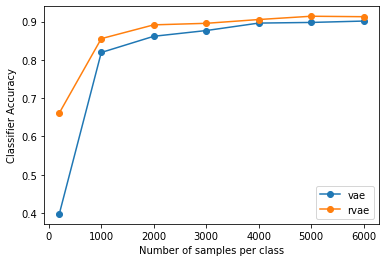

In [12]:
import pickle
with open('saved_models/dict_vae_z_100_rotated_classifier_200.pkl', 'rb') as handle:
    vae_results_samples_200 = pickle.load(handle)['val_accs'][-1]
with open('saved_models/dict_vae_z_100_rotated_classifier_1000.pkl', 'rb') as handle:
    vae_results_samples_1000 = pickle.load(handle)['val_accs'][-1]
with open('saved_models/dict_vae_z_100_rotated_classifier_2000.pkl', 'rb') as handle:
    vae_results_samples_2000 = pickle.load(handle)['val_accs'][-1]
with open('saved_models/dict_vae_z_100_rotated_classifier_3000.pkl', 'rb') as handle:
    vae_results_samples_3000 = pickle.load(handle)['val_accs'][-1]
with open('saved_models/dict_vae_z_100_rotated_classifier_4000.pkl', 'rb') as handle:
    vae_results_samples_4000 = pickle.load(handle)['val_accs'][-1]
with open('saved_models/dict_vae_z_100_rotated_classifier_5000.pkl', 'rb') as handle:
    vae_results_samples_5000 = pickle.load(handle)['val_accs'][-1]
with open('saved_models/dict_vae_z_100_rotated_classifier_6000.pkl', 'rb') as handle:
    vae_results_samples_6000 = pickle.load(handle)['val_accs'][-1]
    
    
with open('saved_models/dict_rvae_z_100_rotated_classifier_200.pkl', 'rb') as handle:
    rvae_results_samples_200 = pickle.load(handle)['val_accs'][-1]
with open('saved_models/dict_rvae_z_100_rotated_classifier_1000.pkl', 'rb') as handle:
    rvae_results_samples_1000 = pickle.load(handle)['val_accs'][-1]
with open('saved_models/dict_rvae_z_100_rotated_classifier_2000.pkl', 'rb') as handle:
    rvae_results_samples_2000 = pickle.load(handle)['val_accs'][-1]
with open('saved_models/dict_rvae_z_100_rotated_classifier_3000.pkl', 'rb') as handle:
    rvae_results_samples_3000 = pickle.load(handle)['val_accs'][-1]
with open('saved_models/dict_rvae_z_100_rotated_classifier_4000.pkl', 'rb') as handle:
    rvae_results_samples_4000 = pickle.load(handle)['val_accs'][-1]
with open('saved_models/dict_rvae_z_100_rotated_classifier_5000.pkl', 'rb') as handle:
    rvae_results_samples_5000 = pickle.load(handle)['val_accs'][-1]
with open('saved_models/dict_rvae_z_100_rotated_classifier_6000.pkl', 'rb') as handle:
    rvae_results_samples_6000 = pickle.load(handle)['val_accs'][-1]

x = [200, 1000, 2000, 3000, 4000, 5000, 6000]
y1 = [vae_results_samples_200, vae_results_samples_1000, vae_results_samples_2000, vae_results_samples_3000, 
      vae_results_samples_4000, vae_results_samples_5000, vae_results_samples_6000]
y2 = [rvae_results_samples_200, rvae_results_samples_1000, rvae_results_samples_2000, rvae_results_samples_3000, 
     rvae_results_samples_4000, rvae_results_samples_5000, rvae_results_samples_6000]
plt.plot(x, y1, label = 'vae', marker='o')
plt.plot(x, y2, label = 'rvae', marker='o')
plt.legend(loc='lower right')
plt.xlabel('Number of samples per class')
plt.ylabel('Classifier Accuracy')
plt.savefig("plots/sample_complexity.svg", bbox_inches='tight')
plt.show()

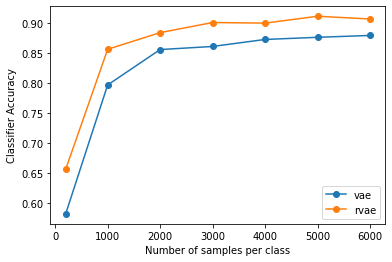

In [13]:
import pickle
with open('saved_models/dict_vae_z_10_rotated_classifier_200.pkl', 'rb') as handle:
    vae_results_samples_200 = pickle.load(handle)['val_accs'][-1]
with open('saved_models/dict_vae_z_10_rotated_classifier_1000.pkl', 'rb') as handle:
    vae_results_samples_1000 = pickle.load(handle)['val_accs'][-1]
with open('saved_models/dict_vae_z_10_rotated_classifier_2000.pkl', 'rb') as handle:
    vae_results_samples_2000 = pickle.load(handle)['val_accs'][-1]
with open('saved_models/dict_vae_z_10_rotated_classifier_3000.pkl', 'rb') as handle:
    vae_results_samples_3000 = pickle.load(handle)['val_accs'][-1]
with open('saved_models/dict_vae_z_10_rotated_classifier_4000.pkl', 'rb') as handle:
    vae_results_samples_4000 = pickle.load(handle)['val_accs'][-1]
with open('saved_models/dict_vae_z_10_rotated_classifier_5000.pkl', 'rb') as handle:
    vae_results_samples_5000 = pickle.load(handle)['val_accs'][-1]
with open('saved_models/dict_vae_z_10_rotated_classifier_6000.pkl', 'rb') as handle:
    vae_results_samples_6000 = pickle.load(handle)['val_accs'][-1]
    
    
with open('saved_models/dict_rvae_z_10_rotated_classifier_200.pkl', 'rb') as handle:
    rvae_results_samples_200 = pickle.load(handle)['val_accs'][-1]
with open('saved_models/dict_rvae_z_10_rotated_classifier_1000.pkl', 'rb') as handle:
    rvae_results_samples_1000 = pickle.load(handle)['val_accs'][-1]
with open('saved_models/dict_rvae_z_10_rotated_classifier_2000.pkl', 'rb') as handle:
    rvae_results_samples_2000 = pickle.load(handle)['val_accs'][-1]
with open('saved_models/dict_rvae_z_10_rotated_classifier_3000.pkl', 'rb') as handle:
    rvae_results_samples_3000 = pickle.load(handle)['val_accs'][-1]
with open('saved_models/dict_rvae_z_10_rotated_classifier_4000.pkl', 'rb') as handle:
    rvae_results_samples_4000 = pickle.load(handle)['val_accs'][-1]
with open('saved_models/dict_rvae_z_10_rotated_classifier_5000.pkl', 'rb') as handle:
    rvae_results_samples_5000 = pickle.load(handle)['val_accs'][-1]
with open('saved_models/dict_rvae_z_10_rotated_classifier_6000.pkl', 'rb') as handle:
    rvae_results_samples_6000 = pickle.load(handle)['val_accs'][-1]

x = [200, 1000, 2000, 3000, 4000, 5000, 6000]
y1 = [vae_results_samples_200, vae_results_samples_1000, vae_results_samples_2000, vae_results_samples_3000, 
      vae_results_samples_4000, vae_results_samples_5000, vae_results_samples_6000]
y2 = [rvae_results_samples_200, rvae_results_samples_1000, rvae_results_samples_2000, rvae_results_samples_3000, 
     rvae_results_samples_4000, rvae_results_samples_5000, rvae_results_samples_6000]
plt.plot(x, y1, label = 'vae', marker='o')
plt.plot(x, y2, label = 'rvae', marker='o')
plt.legend(loc='lower right')
plt.xlabel('Number of samples per class')
plt.ylabel('Classifier Accuracy')
plt.savefig("plots/sample_complexity_z_10.svg", bbox_inches='tight')
plt.show()

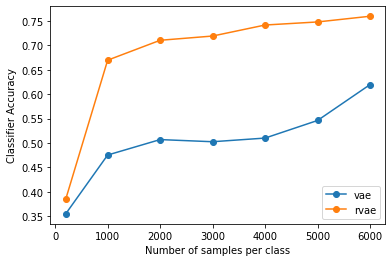

In [14]:
import pickle
with open('saved_models/dict_vae_z_2_rotated_classifier_200.pkl', 'rb') as handle:
    vae_results_samples_200 = pickle.load(handle)['val_accs'][-1]
with open('saved_models/dict_vae_z_2_rotated_classifier_1000.pkl', 'rb') as handle:
    vae_results_samples_1000 = pickle.load(handle)['val_accs'][-1]
with open('saved_models/dict_vae_z_2_rotated_classifier_2000.pkl', 'rb') as handle:
    vae_results_samples_2000 = pickle.load(handle)['val_accs'][-1]
with open('saved_models/dict_vae_z_2_rotated_classifier_3000.pkl', 'rb') as handle:
    vae_results_samples_3000 = pickle.load(handle)['val_accs'][-1]
with open('saved_models/dict_vae_z_2_rotated_classifier_4000.pkl', 'rb') as handle:
    vae_results_samples_4000 = pickle.load(handle)['val_accs'][-1]
with open('saved_models/dict_vae_z_2_rotated_classifier_5000.pkl', 'rb') as handle:
    vae_results_samples_5000 = pickle.load(handle)['val_accs'][-1]
with open('saved_models/dict_vae_z_2_rotated_classifier_6000.pkl', 'rb') as handle:
    vae_results_samples_6000 = pickle.load(handle)['val_accs'][-1]
    
    
with open('saved_models/dict_rvae_z_2_rotated_classifier_200.pkl', 'rb') as handle:
    rvae_results_samples_200 = pickle.load(handle)['val_accs'][-1]
with open('saved_models/dict_rvae_z_2_rotated_classifier_1000.pkl', 'rb') as handle:
    rvae_results_samples_1000 = pickle.load(handle)['val_accs'][-1]
with open('saved_models/dict_rvae_z_2_rotated_classifier_2000.pkl', 'rb') as handle:
    rvae_results_samples_2000 = pickle.load(handle)['val_accs'][-1]
with open('saved_models/dict_rvae_z_2_rotated_classifier_3000.pkl', 'rb') as handle:
    rvae_results_samples_3000 = pickle.load(handle)['val_accs'][-1]
with open('saved_models/dict_rvae_z_2_rotated_classifier_4000.pkl', 'rb') as handle:
    rvae_results_samples_4000 = pickle.load(handle)['val_accs'][-1]
with open('saved_models/dict_rvae_z_2_rotated_classifier_5000.pkl', 'rb') as handle:
    rvae_results_samples_5000 = pickle.load(handle)['val_accs'][-1]
with open('saved_models/dict_rvae_z_2_rotated_classifier_6000.pkl', 'rb') as handle:
    rvae_results_samples_6000 = pickle.load(handle)['val_accs'][-1]

x = [200, 1000, 2000, 3000, 4000, 5000, 6000]
y1 = [vae_results_samples_200, vae_results_samples_1000, vae_results_samples_2000, vae_results_samples_3000, 
      vae_results_samples_4000, vae_results_samples_5000, vae_results_samples_6000]
y2 = [rvae_results_samples_200, rvae_results_samples_1000, rvae_results_samples_2000, rvae_results_samples_3000, 
     rvae_results_samples_4000, rvae_results_samples_5000, rvae_results_samples_6000]
plt.plot(x, y1, label = 'vae', marker='o')
plt.plot(x, y2, label = 'rvae', marker='o')
plt.legend(loc='lower right')
plt.xlabel('Number of samples per class')
plt.ylabel('Classifier Accuracy')
plt.savefig("plots/sample_complexity_z_2.svg", bbox_inches='tight')
plt.show()